# Overview

According to the [homepage](https://mlflow.org/) MLFlow is "An open source platform for the machine learning lifecycle". Its intended purpose is to provide a single tool which allows data scientists to address ML specific components of the Software Development Life cycle (SDLC) including: experimentation, reproducibility, model deployment, and a model storage in a centralizing model registry.

The project breaks down into the following sub-components:
- MLflow Tracking - Allows user to record and query experiments: code, data, config, and results
- MLflow Projects - A standard package format allowing reproducable deployments of models to any platform regardless of where they were authored
- MLflow Models - A unified abstraction layer allowing support for integration with multiple machine learning model libraries and providers
- Model Registry - Store, annotate, discover, and manage models in a central repository

We will see that each sub-component has a coresponding UI and API.

The project page boasts integrations with many big name players, providers, and technology stacks and sees contributions coming from many big names in the space.

## Agenda

In this notebook we will get our feet wet and explore the basic functionalities. For official documentation, see the [MLFlow quickstart guide](https://mlflow.org/docs/latest/quickstart.html).



# 1. MLFlow Architecture

Before we get started with MLFlow, It is important to understand the architectural components. As we will see in section 2, there are a number of ways to deploy the MLFlow. Before we choose a method, it is important to understand that an MLFlow deployment consists of the following components:
- Backend - Persists MLflow entities (runs, parameters, metrics, tags, notes, metadata, etc)
- Artifact Store - persists artifacts (files, models, images, in-memory objects, or model summary, etc)
- REST API - The optional component exposing web based MLFlow API
- Tracking UI - The Web UI for lets you visualize, search and compare runs, as well as download run artifacts or metadata for analysis in other tools, and register or tag models.



# 2. Deployment Options

Reading through the [documentation](https://mlflow.org/docs/latest/tracking.html), assuming you are deploying your own MLFlow installation, you have the following documented options:

<table >
	<tbody>
		<tr>
			<td>Scenario</td>
			<td>Description</td>
			<td>Backend</td>
			<td>Artifact Store</td>
		</tr>
		<tr>
			<td>1</td>
			<td>MLflow on localhost</td>
			<td>local ./mlruns&nbsp;directory</td>
			<td>local ./mlruns&nbsp;directory</td>
		</tr>
		<tr>
			<td>2</td>
			<td>MLflow on localhost with SQLite</td>
			<td>local ./mlruns directory</td>
			<td>local mlruns.db file</td>
		</tr>
		<tr>
			<td>3</td>
			<td>MLflow on localhost with Tracking Server</td>
			<td>A REST API utilizes&nbsp;./mlruns directory</td>
			<td>A REST API utilizes ./mlruns directory</td>
		</tr>
		<tr>
			<td>4</td>
			<td>MLflow with remote Tracking Server, backend and artifact stores</td>
			<td>A REST API utilizes remote backend</td>
			<td>A REST API utilizes remote artifact store</td>
		</tr>
	</tbody>
</table>

**Note**: None of these options discuss the MLFlow UI.

Databricks and AWS also provide MLFlow deployments that data scientists can leverage.

For our purposes, we will keep it simple and go with scenario 1 and host our own UI.

# 3. MLFLow Object Model

# 4. Launching MLFlow
Launching MLFlow from a jupyter notebook is a bit complicated. Long story short; we will need to launch the process in a separate thread so that the jupyter cell does not block us by running forever.

In [21]:
shell_command = "mlflow ui"
mlflow_port = 5000

def mlflow_running():
    import socket
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        running = s.connect_ex(('localhost', mlflow_port)) == 0
        return running
    
if mlflow_running():
    print("It looks like MLFlow is already running. Check is python.exe is listening on port 5000 ")
else:
    print("Starting MLFlow")
    import subprocess
    process = subprocess.Popen(shell_command)
print("MLFlow should be accessible at http://localhost:5000")

It looks like MLFlow is already running. Check is python.exe is listening on port 5000 
MLFlow should be accessible at http://localhost:5000


Once launched, you should see a page like this:

<center><img src="images/mlflow_ui.png" ></center>

# 5. Example Workflow
## 5.1. Load Data
In our example we will load some NASDAQ data and train a model to make predictions. 

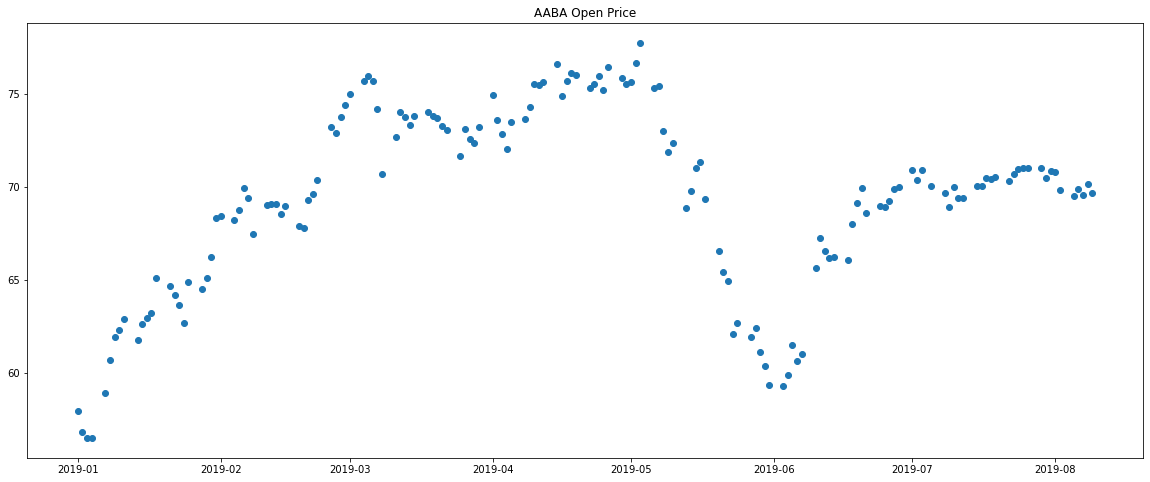

In [81]:
# Import the utilities module we wrote
import importlib.util
spec = importlib.util.spec_from_file_location("utilities", "../../Utilities/utilities.py")
utilities = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utilities)

# Read the file into a dataframe
file_path = "../../Example Data Sets/nasdaq_2019.csv"
converter_mapping = {
    "date": utilities.convert_date_string_to_date
}
import pandas
pandas_dataframe = pandas.read_csv(file_path, converters=converter_mapping)
aaba_dataframe = pandas_dataframe[pandas_dataframe["ticker"] == 'AABA']
aaba_dataframe = aaba_dataframe.sort_values(by="date", ascending=True)

# Plot the data
import matplotlib.pyplot as pyplot
fig, ax = pyplot.subplots(figsize=(20, 8), nrows=1, ncols=1)
ax.set_title("AABA Open Price")
pyplot.scatter(aaba_dataframe["date"], aaba_dataframe["open"]);

## 5.2. Train The ARIMA Model

The model we will be using is the ARIMA model which stands for:

- AutoRegressive (AR) - the model takes advantage of the connection between a predefined number of lagged observations and the current one.
- Integrated (I) - differencing between raw observations (eg. subtracting observations at different time steps).
- Moving Average (MA) - the model takes advantage of the relationship between the residual error and the observations.

The ARIMA model makes use of three main parameters (p,d,q):
- p - number of lag observations
- d - the degree of differencing
- q - the size of the moving average window


In [48]:
import warnings
warnings.filterwarnings('ignore')

We will then iterate through a number of training and testing scenarios choosing the best parameters for the predictions.

In [107]:
import itertools
import statsmodels.api

# Split the data into a train and test set
datapoint_count = aaba_dataframe.shape[0]
split_point = int(datapoint_count * 0.8)
train_df = aaba_dataframe[:split_point]
test_df = aaba_dataframe[split_point:]

# Generate the posisble parameters for the model
p = d = q = range(0, 3)
pdq_combinations = list(itertools.product(p, d, q))

# Train the model
#      Find the optimal parameter set and the coresponding performance metric
#

best_param_set = None
best_perf_metric = -1

for pdq in pdq_combinations:
    
    # Create the model
    model = statsmodels.api.tsa.statespace.SARIMAX(
        train_df["open"], 
        order=pdq, 
        enforce_stationarity=True, 
        enforce_invertibility=True)
    
    # Fit the model to the data
    fit_model = model.fit()
    
    # Calculate performance metric
    aic = fit_model.aic
    
    # Record the results
    if aic < best_perf_metric or best_perf_metric == -1:
        best_param_set = pdq
        best_perf_metric = aic

    #print("The parameter set {} yielded an AIC of {}".format(pdq, aic))

print("The best parameter set {} yielded an AIC of {}".format(best_param_set, best_perf_metric))
fit_model.summary()

The best parameter set (0, 1, 0) yielded an AIC of 409.4944259259052


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   open   No. Observations:                  126
Model:               SARIMAX(2, 2, 2)   Log Likelihood                -202.800
Date:                Fri, 11 Jun 2021   AIC                            415.600
Time:                        22:26:31   BIC                            429.702
Sample:                             0   HQIC                           421.329
                                - 126                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8990      0.093     -9.686      0.000      -1.081      -0.717
ar.L2          0.0379      0.087      0.436      0.663      -0.133       0.208
ma.L1          0.0319     15.866      0.002      0.998     -31.066      31.130
ma.L2         -0.9680     15.372     -0.063      0.950     -31.097      29.161
sigma2         1.4904     23.588      0.063      0.950     -44.742      47.723
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.83
Prob(Q):                              0.99   Prob(JB):                         0.01
Heteroskedasticity (H):               1.90   Skew:                            -0.00
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 5.3. Test The Model
We can make predictions using our fit model:

In [159]:
# Make predictions using the fit model
points_to_predict = datapoint_count - split_point
points_to_predict
alpha = 0.05
predictions = fit_model.forecast(points_to_predict, alpha=alpha)  # 95% conf

# Calculate the upper and lower bound for the confidence interval
forecast = fit_model.get_forecast(points_to_predict)
ci = forecast.conf_int()

Plotting our predictions we see:

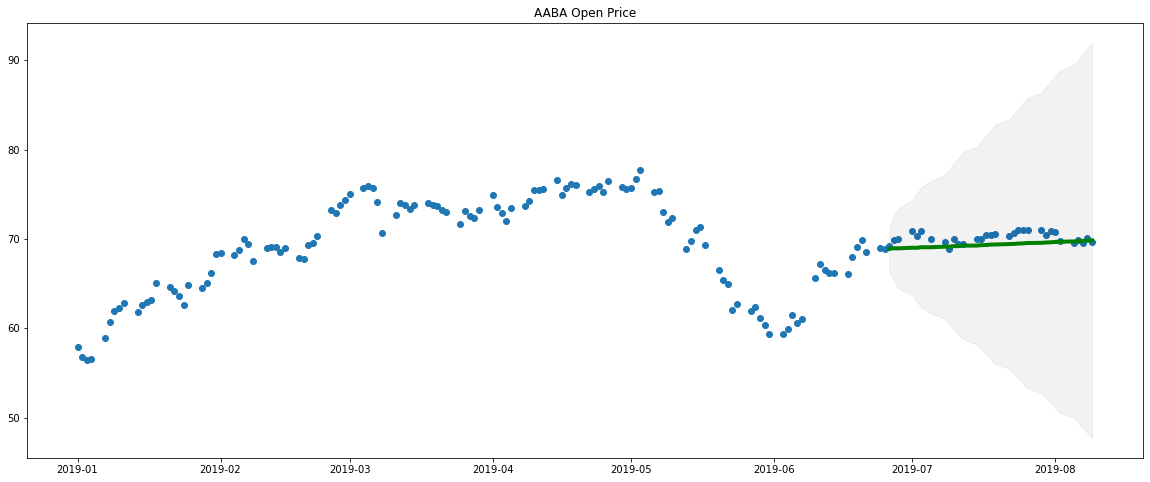

In [158]:
fig, ax = pyplot.subplots(figsize=(20, 8), nrows=1, ncols=1)
ax.set_title("AABA Open Price")
ax.scatter(aaba_dataframe["date"], aaba_dataframe["open"])
ax.plot(aaba_dataframe["date"][split_point:], predictions, color="green", linewidth=4);

lower_series= ci.iloc[:, 0]
upper_series= ci.iloc[:, 1]
ax.fill_between(aaba_dataframe["date"][split_point:], lower_series, upper_series, color='k', alpha=alpha);

We can quantify the error from our test trial:

In [177]:
import math
import numpy

y_actual = test_df["open"].to_numpy()
y_predicted = predictions

MSE = numpy.square(numpy.subtract(y_actual,y_predicted)).mean()
RMSE = math.sqrt(MSE)

print("The MSE is: {}".format(MSE))
print("The RMSE is: {}".format(RMSE))

The MSE is: 1.0199129847785446
The RMSE is: 1.0099074139635498


# 6. Configure MLFlow Connection
We need to tell our MLFlow client where the server is and how to connect.

In [179]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

We can verify the connection settings as follows:

In [183]:
mlflow.get_tracking_uri()

'http://127.0.0.1:5000'

# 7. Conduct An Experiment

Usint the MLFLow Tracking API we are able to log model paramters, metics, and artifacts to the MLFlow server.

The first thing we need to do is tell MLFlow which experiment we are working on

## 7.1. Create The Experiment Object
The experiment object allows us logically group runs which serve a common task. In our case, the act of training the model, testing the model, and calculating performance metrics can all be considered a run. The larger experiment is thus observing the different runs so that we can choose the best performing model parameters.

As MLFlow is operating on a distributed model, we have the ability to attach to existing experiments or define new ones. Before creating one, we will observe that there is a default experiment which is automagically created for us.

In [194]:
from  mlflow.tracking import MlflowClient
mlflow_client = MlflowClient()
experiments = mlflow_client.list_experiments()
experiments

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>]

We will create a different experiment to store information from our runs. We will name the experiment AABA-ARIMA

In [211]:
experiment_name = 'AABA-ARIMA'
mlflow.set_experiment(experiment_name)

INFO: 'AABA-ARIMA' does not exist. Creating a new experiment


In [212]:
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='AABA-ARIMA', tags={}>

In [214]:
mlflow_client.list_experiments()

[<Experiment: artifact_location='./mlruns/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='AABA-ARIMA', tags={}>]

## 7.2. Conduct The Experiment And Log Run Data
We can now run through our ML workflow from section 5. 